# 应用聚类模型

在本实验中，您将应用K-means和凝聚来聚类以寻找汽车数据集中的结构。 在这样一个复杂的数据集中寻找有意义的集群将具有挑战性。 挑战是双重的。 首先，必须确定最佳簇数，然后必须以某种有用的方式解释聚类。 这些挑战是无监督学习的典型挑战。



## 准备数据集

在开始构建和评估群集模型之前，必须准备数据集。 首先，执行下面单元格中的代码以加载运行其余部分所需的包。


In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

下面单元格中的代码加载了一个准备好的autos数据集版本，该版本具有以下预处理：
1. 清除缺失值。
2. 汇总某些分类变量的类别。
3. 将分类变量编码为二进制虚拟变量。
4. 标准化数值变量。

但是，对于这种情况，需要一些额外的处理：
1. 采用Label向量的日志。您从之前的分析中了解到，标签（价格）值的日志更接近于与几个数字特征线性相关。此外，Label的日志更接近Normally distributed。
2. 标签值为Zscore标准化，以确保方差为1.0，平均值为0.0。与所有机器学习一样，缩放在群集分析中至关重要，以避免解决方案中出现偏差。
3. 将缩放的对数变换后的Label值向量附加到要素上以创建完整的数据集。

执行下面单元格中的代码以创建数据集所需的处理：


In [2]:
Features = np.array(pd.read_csv('Auto_Data_Features.csv'))
Labels = np.array(pd.read_csv('Auto_Data_Labels.csv'))
Labels = np.log(Labels)
scaler = StandardScaler()
Labels = scaler.fit_transform(Labels)
Auto_Data = np.concatenate((Features,Labels), 1)
print(Auto_Data.shape)

(195, 46)


请注意，对于少数情况，数据集有46列（维度）195行，与特征数量相比较少的行增加了此问题的挑战。



In [3]:
auto_prices = pd.read_csv('Automobile price data _Raw_.csv')

def clean_auto_data(auto_prices):
    'Function to load the auto price data set from a .csv file' 
    import pandas as pd
    import numpy as np
    
    ## Remove rows with missing values, accounting for mising values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm']
    for column in cols:
        auto_prices.loc[auto_prices[column] == '?', column] = np.nan
    auto_prices.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_prices[column] = pd.to_numeric(auto_prices[column])
    
    ## fix column names so the '-' character becomes '_'
    cols = auto_prices.columns
    auto_prices.columns = [str.replace('-', '_') for str in cols]
        
    return auto_prices
auto_prices = clean_auto_data(auto_prices)

print(auto_prices.columns)

Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
       'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
       'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')


价格列应进行对数转换。 执行下面单元格中的代码：

In [4]:
auto_prices['price'] = np.log(auto_prices['price'])

最后一点需要准备，通过以下代码创建分配可视化的标记形状列表。 使用的键是燃料类型和排气的元组， 执行下面单元格中的代码以创建此列表。

In [4]:
marker_dic = {('gas','std'):'o', ('gas','turbo'):'s', ('diesel','std'):'x', ('diesel','turbo'):'^'}
markers = [marker_dic[(x,y)] for x,y in zip(auto_prices['fuel_type'], auto_prices['aspiration'])]

## 应用K-means聚类

准备好数据后，您将创建并评估应用于汽车数据集的一系列K-means聚类模型。

下面单元格中的代码执行以下处理：
1. 定义字典用于将聚类分配编号映射到分配可视化的颜色。
2. 定义了K = 2 K均值的聚类模型。
3. 数据适合群集模型并计算分配。
4. 分配映射到颜色列表。

执行此代码。


In [5]:
nr.seed(2233)
col_dic = {0:'blue',1:'green',2:'orange',3:'gray',4:'magenta',5:'black'}
kmeans_2 = KMeans(n_clusters=2, random_state=0)
assignments_km2 = kmeans_2.fit_predict(Auto_Data)
assign_color_km2 = [col_dic[x] for x in assignments_km2]

接下来，下面单元格中的代码绘制了聚类分配的四个视图。 对于高维数据，许多视图都是可能的。 但是，考虑到感知的限制，通常最好选择一些有意义的视角。 在这种情况下，显示5个数字列和2个分类变量，共45个可能的维度中的7个。

下面单元格中的函数执行以下处理：
1. 显示数字列的列表。
2. 外循环迭代列，4个绘图轴的索引。
3. 内循环迭代x和y坐标，颜色和标记形状， 这些点被绘制在该循环内
4. 添加了绘图的注释。

执行此代码以显示K = 2模型的聚类。


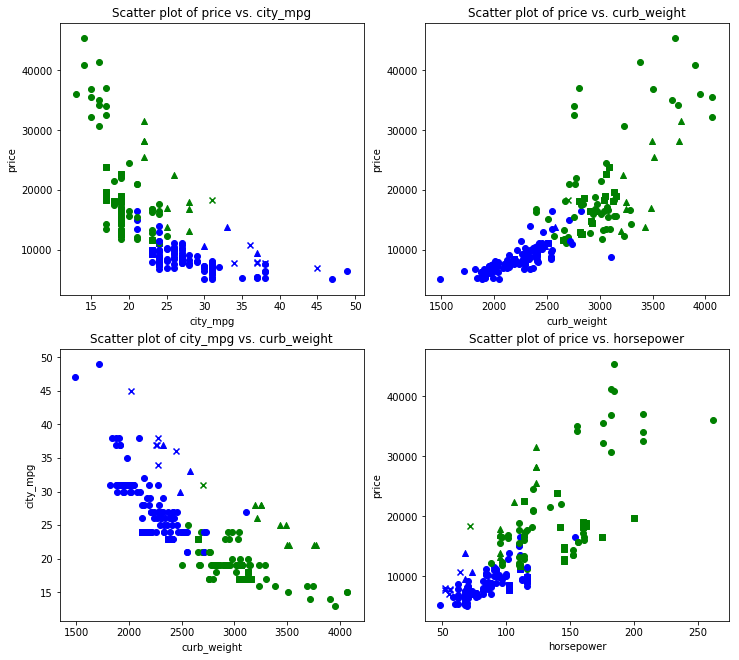

In [6]:
def plot_auto_cluster(auto_prices, assign_color, markers):
    fig, ax = plt.subplots(2, 2, figsize=(12,11)) # define plot area         
    x_cols = ['city_mpg', 'curb_weight', 'curb_weight', 'horsepower']
    y_cols = ['price', 'price', 'city_mpg', 'price']
    for x_col,y_col,i,j in zip(x_cols,y_cols,[0,0,1,1],[0,1,0,1]):
        for x,y,c,m in zip(auto_prices[x_col], auto_prices[y_col], assign_color, markers):
            ax[i,j].scatter(x,y, color = c, marker = m)
        ax[i,j].set_title('Scatter plot of ' + y_col + ' vs. ' + x_col) # Give the plot a main title
        ax[i,j].set_xlabel(x_col) # Set text for the x axis
        ax[i,j].set_ylabel(y_col)# Set text for y axis
    plt.show()

plot_auto_cluster(auto_prices, assign_color_km2, markers)

K = 2聚类模型将数据分为高价格，低燃油效率，高重量和高马力的汽车以及具有相反特征的汽车。 

接下来，执行下面单元格中的代码，计算并显示K = 3模型的集群分配。


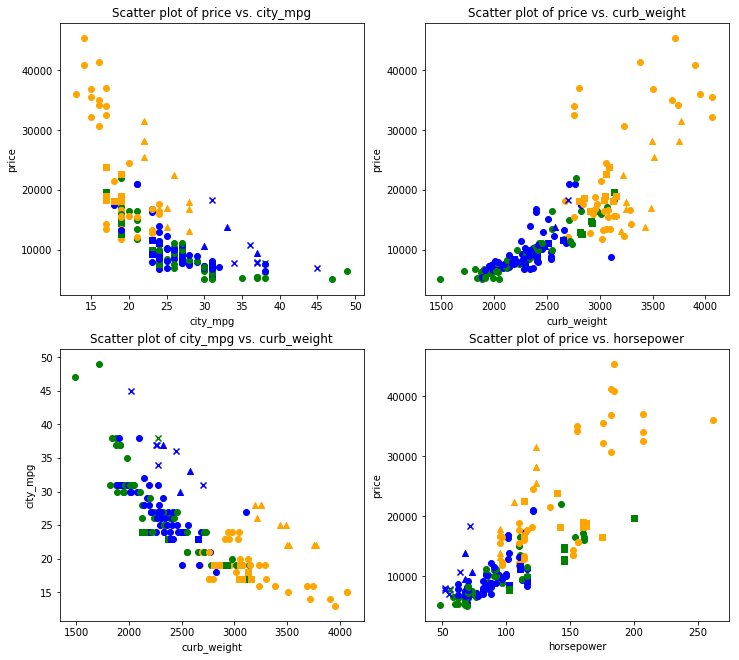

In [10]:
nr.seed(4455)
kmeans_3 = KMeans(n_clusters=3, random_state=0)
assignments_km3 = kmeans_3.fit_predict(Auto_Data)
assign_color_km3 = [col_dic[x] for x in assignments_km3]
plot_auto_cluster(auto_prices, assign_color_km3, markers)

聚类数据集的基本划分类似于K = 2模型的情况。 然而，这些聚类的重叠明显多于K = 2的情况。 标准的抽吸汽车都在蓝色显示的集群中。 除此之外，还不确定是否已经学习了关于该数据集结构的新信息。

执行下面单元格中的代码以计算和显示K = 4模型的集群分配。


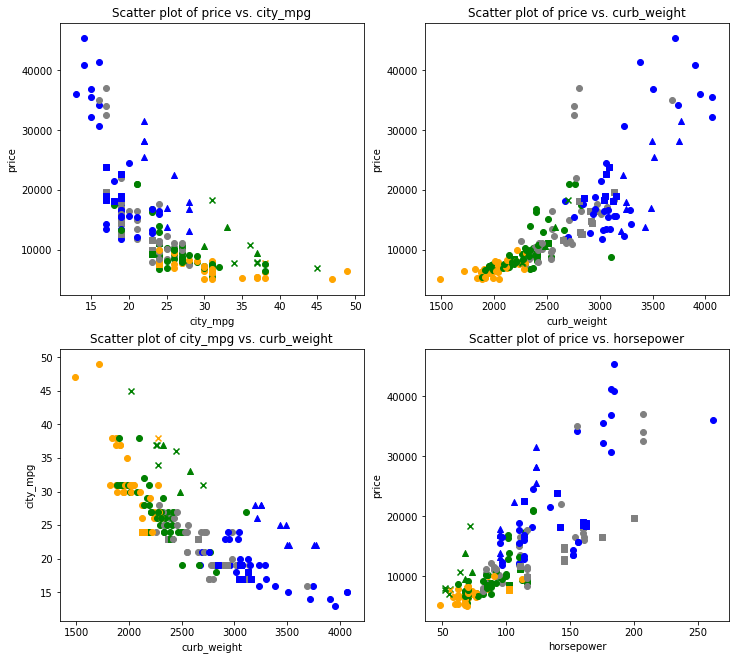

In [11]:
nr.seed(223)
kmeans_4 = KMeans(n_clusters=4, random_state=0)
assignments_km4 = kmeans_4.fit_predict(Auto_Data)
assign_color_km4 = [col_dic[x] for x in assignments_km4]
plot_auto_cluster(auto_prices, assign_color_km4, markers)

与k = 4模型相比，似乎重叠较少。 此外，一些额外的有趣结构开始出现。 这些聚类的主要指标是按价格，重量，燃油效率和马力。 所有柴油汽车分为两组，一组有成本高的重量和马力为蓝色，另一组有成本较低的重量和马力为橙色。

执行下面单元格中的代码以计算和显示K = 5模型的集群分配。



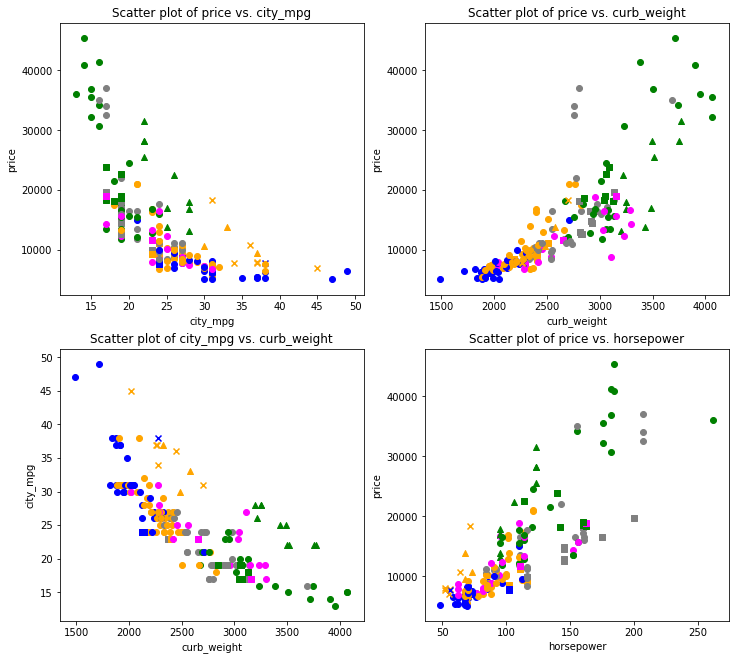

In [12]:
nr.seed(4443)
kmeans_5 = KMeans(n_clusters=5, random_state=0)
assignments_km5 = kmeans_5.fit_predict(Auto_Data)
assign_color_km5 = [col_dic[x] for x in assignments_km5]
plot_auto_cluster(auto_prices, assign_color_km5, markers)

这些集群的结构相当复杂， 一般模式类似于K = 4模型，但在聚类之间具有更细粒度的划分。

最后，执行下面单元格中的代码，计算并显示K = 6模型的聚类。



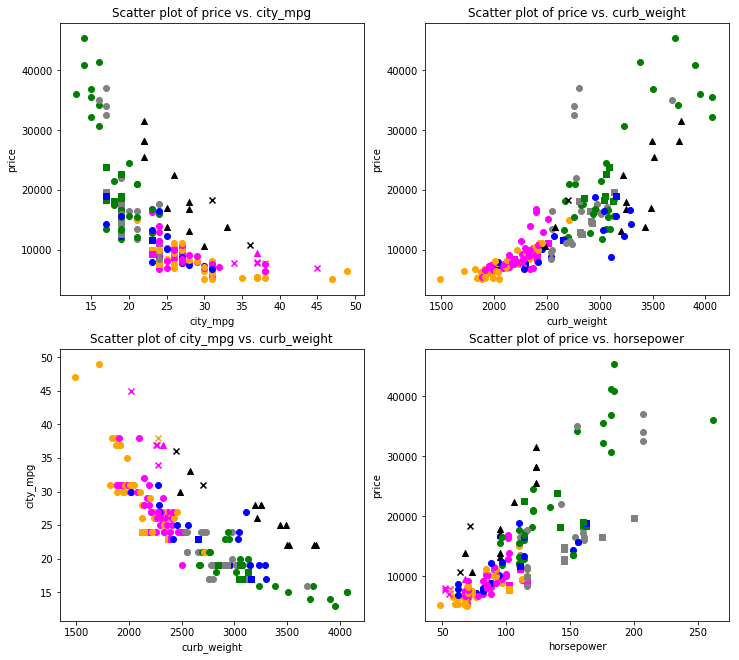

In [13]:
nr.seed(2288)
kmeans_6 = KMeans(n_clusters=6, random_state=0)
assignments_km6 = kmeans_6.fit_predict(Auto_Data)
assign_color_km6 = [col_dic[x] for x in assignments_km6]
plot_auto_cluster(auto_prices, assign_color_km6, markers)

这些簇的结构遵循K = 4和K = 5模型的一般模式，不同之处在于聚类之间存在更细粒度的划分。

虽然这些可视化很有趣，但很难根据这些证据选择最佳模型。 为了建立模型选择的定量基础，您现在将计算和比较聚类内的平方和（WCSS），聚类平方和（BCSS）和轮廓系数（SC）度量。 执行下面单元格中的代码并检查结果。


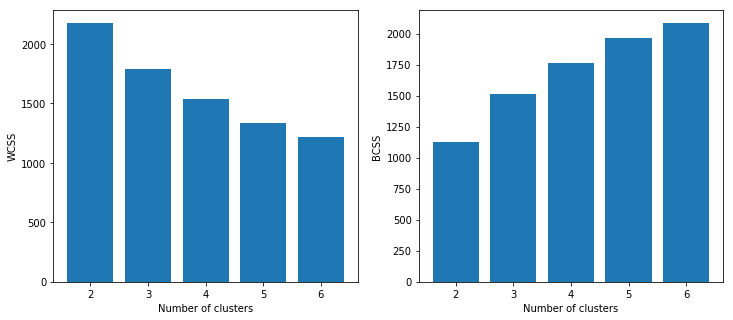

In [14]:
km_models = [kmeans_2, kmeans_3, kmeans_4, kmeans_5, kmeans_6]

def plot_WCSS_km(km_models, samples):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ## Plot WCSS
    wcss = [mod.inertia_ for mod in km_models]
    n_clusts = range(2,len(wcss) + 2)
    ax[0].bar(n_clusts, wcss)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    
    ## Plot BCSS
    ## Compute BCSS as TSS - WCSS 
    n_1 = (float(samples.shape[0]) * float(samples.shape[1])) - 1.0
    tss = n_1 * np.var(samples)
    bcss = [tss - x for x in wcss]
    ax[1].bar(n_clusts, bcss)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    plt.show()
    

plot_WCSS_km(km_models, Auto_Data)

WCSS首先迅速减少簇数。 BCSS随着簇数的增加而增加，这些结果表明，更多数量的聚类创建了更好地分离聚类的模型。

现在，执行下面单元格中的代码，计算并显示每个聚类模型的SC。


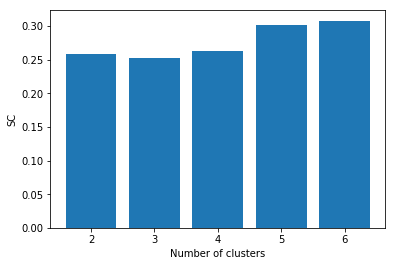

In [15]:
assignment_list = [assignments_km2, assignments_km3, assignments_km4, assignments_km5, assignments_km6]

def plot_sillohette(samples, assignments, x_lab = 'Number of clusters'):
    silhouette = [silhouette_score(samples, a) for a in assignments]
    n_clusts = range(2, len(silhouette) + 2)
    plt.bar(n_clusts, silhouette)
    plt.xlabel(x_lab)
    plt.ylabel('SC')
    plt.show()

plot_sillohette(Auto_Data, assignment_list)

SC在K = 6模型中最高，但仅略高于K = 5。 K = 5和K = 6模型具有显着高于K = 2,3或4的SC。然而，所有这些SC值都相当低。

总的来说，就这些指标而言，k = 6模型似乎是最好的。 似乎K = 5模型也有所改善



## 应用凝聚聚类

尝试了具有不同数量聚类的K-means聚类模式后，您将尝试凝聚聚类模型。 您将使用可视化和SC指标比较这些模型。

下面单元格中的代码计算2聚类凝聚模型并显示聚类分布。 执行此代码：
 

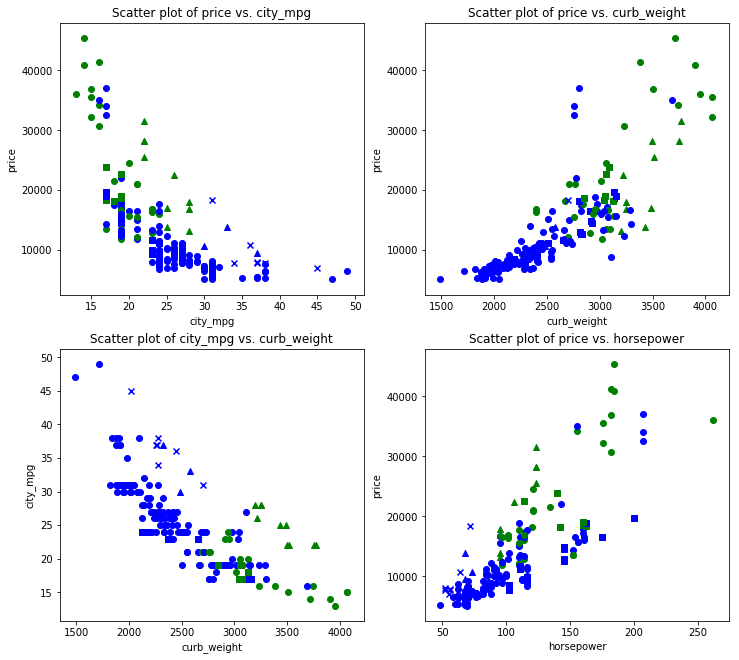

In [21]:
nr.seed(2233)
agc_2 = AgglomerativeClustering(n_clusters=2)
assignments_ag2 = agc_2.fit_predict(Auto_Data)
assign_color_ag2 = [col_dic[x] for x in assignments_ag2]
plot_auto_cluster(auto_prices, assign_color_ag2, markers)

检查上面的图并将它们与K = 2，K-means模型的簇分配进行比较。尽管K-means模型创建了数据集的近似均匀分割，但凝聚聚类模型将大多数点放在一个聚类中。 这些凝聚聚类模型的任务观点存在相当大的重叠。

接下来，执行下面单元格中的代码以计算和显示3簇凝聚模型的分布：


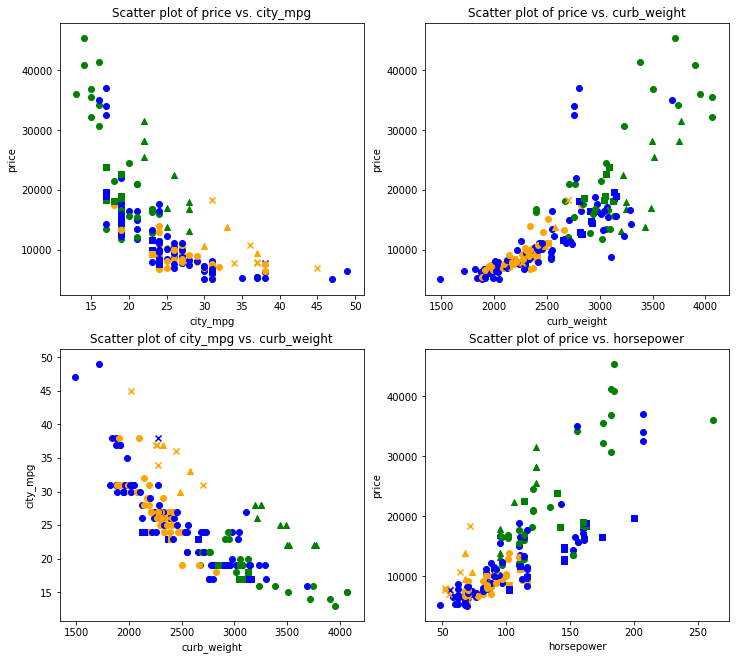

In [22]:
nr.seed(4433)
agc_3 = AgglomerativeClustering(n_clusters=3)
assignments_ag3 = agc_3.fit_predict(Auto_Data)
assign_color_ag3 = [col_dic[x] for x in assignments_ag3]
plot_auto_cluster(auto_prices, assign_color_ag3, markers)

检查这些图并将它们与2簇模型进行比较。看起来3簇模型已经拆分了较大的集合，但在这些集合中仍存在相当大的重叠。

执行下面单元格中的代码以计算和显示4簇凝聚模型的集群分配：



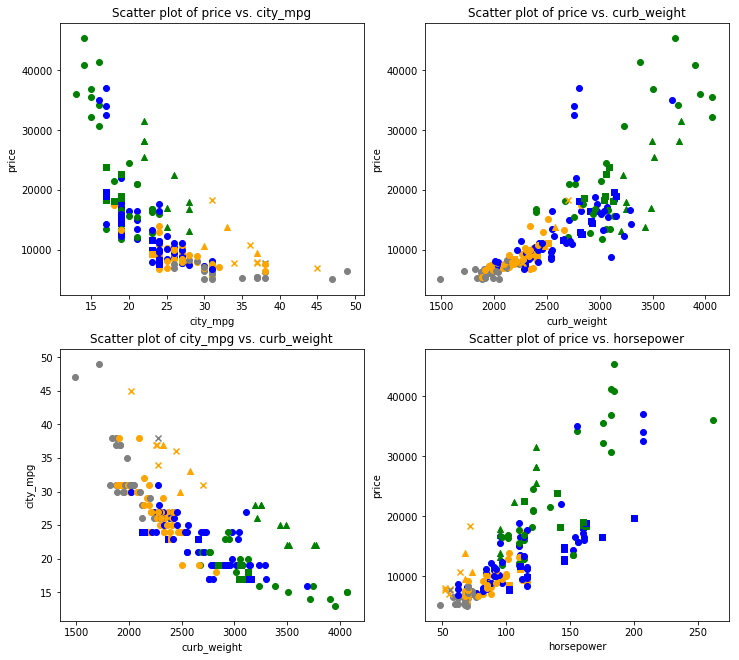

In [23]:
nr.seed(2663)
agc_4 = AgglomerativeClustering(n_clusters=4)
assignments_ag4 = agc_4.fit_predict(Auto_Data)
assign_color_ag4 = [col_dic[x] for x in assignments_ag4]
plot_auto_cluster(auto_prices, assign_color_ag4, markers)

将这些簇分配与3簇模型进行比较。 请注意，低重量，低马力和低成本的汽车已分为两组。 此外，所有柴油车都分为两组。

执行下面单元格中的代码以计算和显示5集群模型的集群分配：

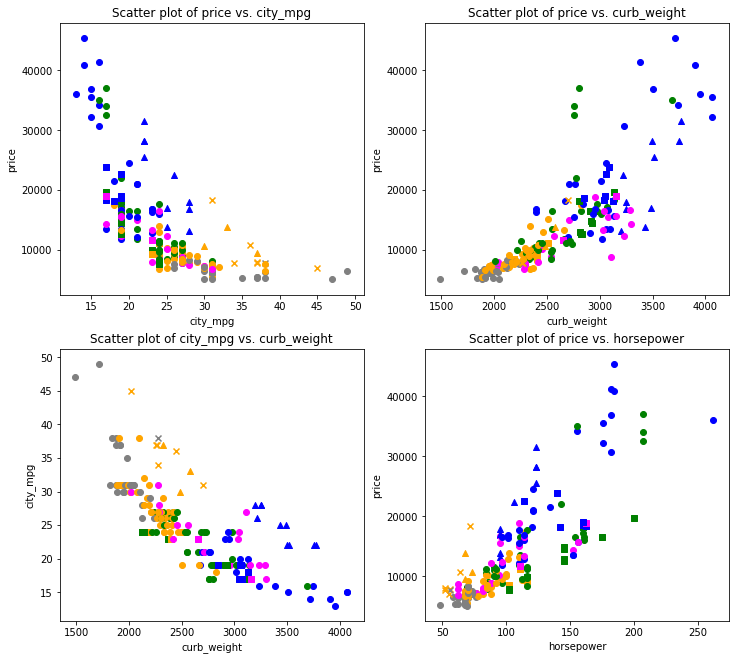

In [24]:
nr.seed(6233)
agc_5 = AgglomerativeClustering(n_clusters=5)
assignments_ag5 = agc_5.fit_predict(Auto_Data)
assign_color_ag5 = [col_dic[x] for x in assignments_ag5]
plot_auto_cluster(auto_prices, assign_color_ag5, markers)

这些结果很复杂，难以解释，现在数据处于多个集群中，并且具有相当大的重叠，然而，例如，一些模式是可见的，其中不同的燃料 - 排气组合被分成不同的簇。

最后，执行下面单元格中的代码，计算并显示6簇凝聚模型的分配。

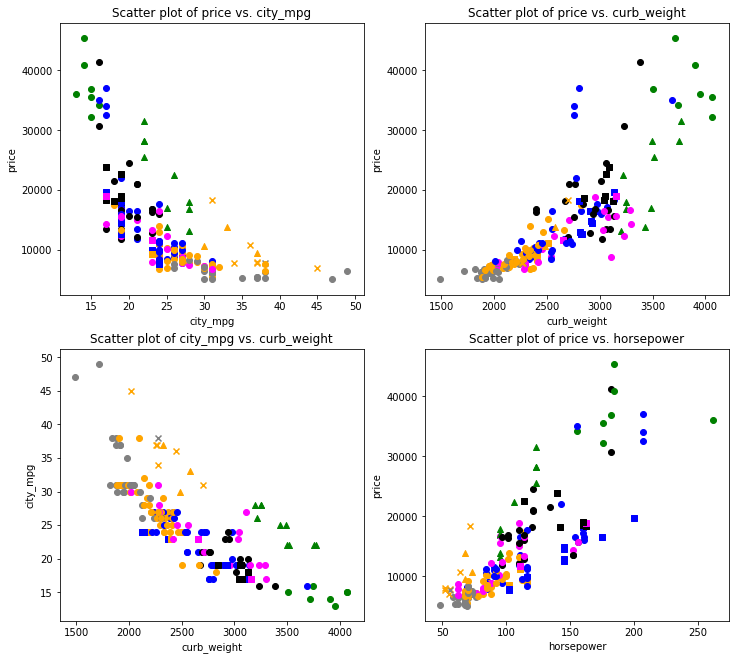

In [25]:
nr.seed(2288)
agc_6 = AgglomerativeClustering(n_clusters=6)
assignments_ag6 = agc_6.fit_predict(Auto_Data)
assign_color_ag6 = [col_dic[x] for x in assignments_ag6]
plot_auto_cluster(auto_prices, assign_color_ag6, markers)

这些结果对于群集凝聚模型而言似乎更简单，一些簇明显分开，但在其他情况下存在相当大的重叠。

最后，执行下面单元格中的代码，计算并显示凝聚聚类模型的SC。

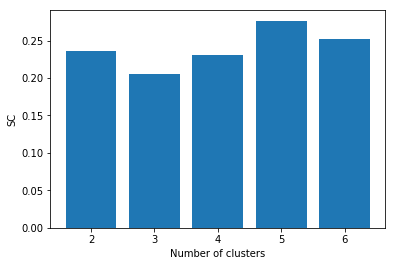

In [26]:
assignment_list = [assignments_ag2, assignments_ag3, assignments_ag4, assignments_ag5, assignments_ag6]
plot_sillohette(Auto_Data, assignment_list)

5簇凝聚模型具有最大的SC，此模型的SC略高于6簇模型。 看来5簇模型是首选。 这些型号都没有特别高的SC。



## 总结

在本实验中，您已经计算，评估和比较了K-means和凝聚聚类模型以及应用于汽车数据集的2,3,4,5和6个聚类。无监督学习已经证明难以对模型进行确切比较，同样确定聚类过程发现的数据结构也成为最有趣和具有挑战性的。

具体来说，您的分析发现：
1. K = 6模型似乎是所尝试的K-means聚类模型中最好的。在该分析中揭示了一些有趣的结构，但总体而言BCSS和SC的减少相对较低。
2. 这5个集群凝聚模型似乎是最好的尝试，与K-means模型一样，揭示了一些有趣的结构，但SC值相对较低。

汽车数据的聚类分析可以通过多种方式进行扩展，包括：
1. 使用更多数量的聚类来确定更精细的分组是否显示结构。
2. 对于凝聚聚类模型，尝试其他链接函数和距离度量。
